In [10]:
"""
Visualization script for multi-run evaluation results.
Creates various plots to analyze system performance across multiple runs.
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
from typing import Optional, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_palette("Spectral")
# Set the default font family
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']




def load_results(results_path: Path) -> pd.DataFrame:
    """Load the combined results CSV file."""
    df = pd.read_csv(results_path)
    print(f"Loaded {len(df)} rows from {results_path}")
    print(f"Systems: {df['system_name'].unique()}")
    print(f"Runs per system: {df.groupby('system_name')['run'].nunique().to_dict()}")
    print(f"Queries: {df['query_name'].unique()}\n")
    return df


def generate_summary_table(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Generate and save a summary statistics table."""
    summary = df.groupby('system_name').agg({
        'quality': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(3)

    # Add count of runs and queries
    counts = df.groupby('system_name').agg({
        'run': 'nunique',
        'query_name': 'nunique'
    })
    counts.columns = ['n_runs', 'n_queries']

    # Combine into final summary
    final_summary = pd.concat([summary, counts], axis=1)

    print("\n" + "="*80)
    print("SUMMARY STATISTICS TABLE")
    print("="*80)
    print(final_summary.to_string())

    if save_path:
        final_summary.to_csv(save_path / 'summary_statistics.csv')
        print(f"\nSummary saved to {save_path / 'summary_statistics.csv'}")

    return final_summary

In [41]:
def plot_performance_scatter(df: pd.DataFrame, subtitle: str, horizontal_line: Optional[float] = None, save_path: Optional[Path] = None):
    """Create scatter plot showing quality vs latency trade-off."""
    fig, ax = plt.subplots(figsize=(6, 4))
    if horizontal_line is not None:
        ax.axhline(y=horizontal_line, color='gray', linestyle='--', linewidth=1.5,
                   alpha=0.7, zorder=2)

    # Create scatter plot with different colors for each system
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    for system, color in zip(systems, colors):
        system_df = df[df['system_name'] == system]

        # Plot individual points
        scatter = ax.scatter(system_df['latency'], system_df['quality'],
                           label=system, alpha=0.6, s=50, color=color,
                           edgecolor='black', linewidth=0.5)

        # Add query labels for each point
        for idx, row in system_df.iterrows():
            # Extract just the query number (e.g., 'Q1' from 'Q1' or '1' from other formats)
            query_label = row['query_name']
            if not query_label.startswith('Q'):
                query_label = f"Q{query_label}"

            # Offset labels slightly to avoid overlap with points
            ax.annotate(query_label,
                       (row['latency'], row['quality']),
                       xytext=(3, 3),  # Offset in pixels
                       textcoords='offset points',
                       fontsize=7,
                       alpha=0.7,
                       color=color)

        # Add mean point with larger marker
        mean_latency = system_df['latency'].mean()
        mean_quality = system_df['quality'].mean()
        ax.scatter(mean_latency, mean_quality,
                  s=200, color=color, marker='D', edgecolor='black', linewidth=2,
                  label=f'{system} (mean)', zorder=5)  # Higher zorder to appear on top

    # Invert x-axis so lower latency (better) is on the right
    ax.invert_xaxis()

    fig.suptitle('Quality vs Latency Trade-off', fontsize=14, fontweight='bold', x=0.41)
    ax.set_title('(Best results in top-right corner)', fontsize=11, style='italic', loc='center')
    ax.set_title(subtitle, fontsize=11, style='italic')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path / 'performance_scatter.png', dpi=400, bbox_inches='tight')
    plt.show()

Loaded 30 rows from src/results/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'thalamusdb']
Runs per system: {'blendsql': 2, 'thalamusdb': 2}
Queries: ['Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q8' 'Q9']



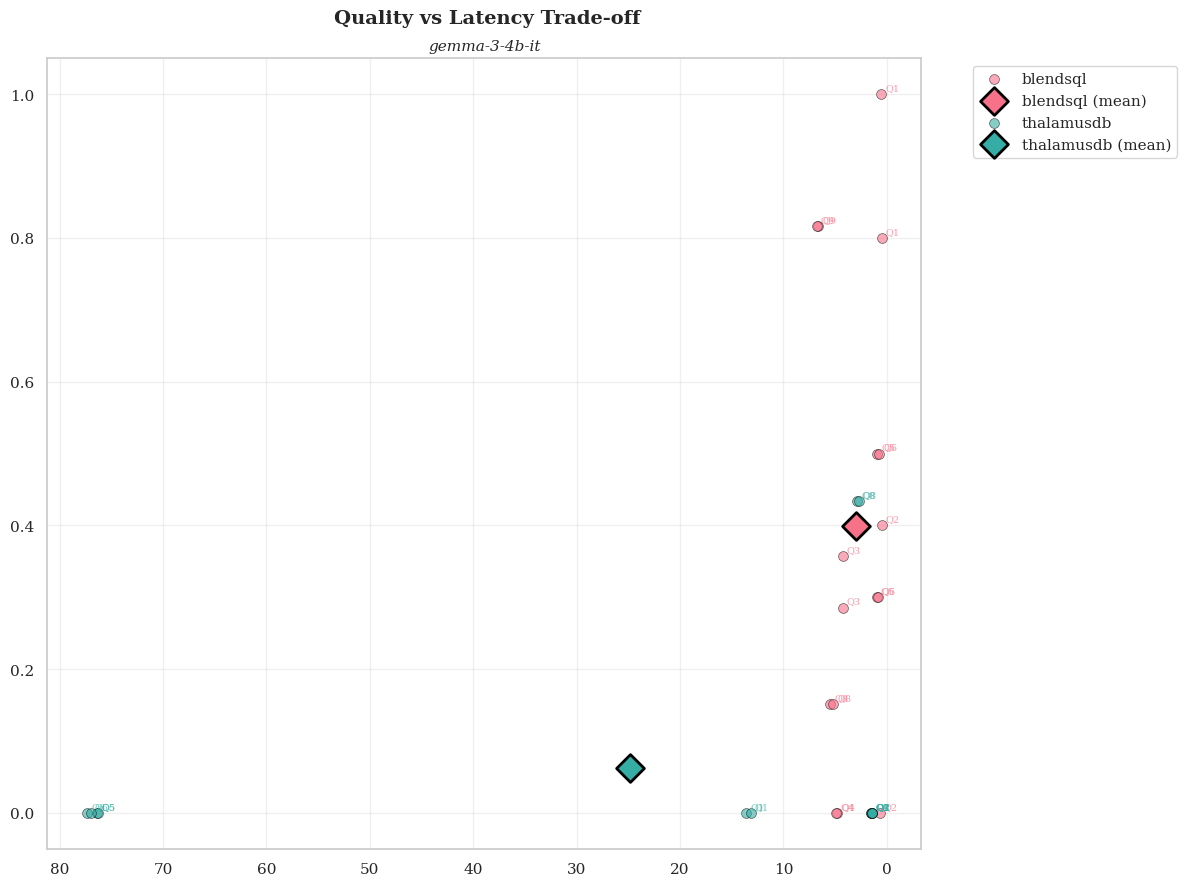

In [42]:
model_path = "unsloth_gemma-3-4b-it-GGUF"
results_path = Path(f"src/results/{model_path}/all_results_with_runs.csv")
output_dir = results_path.parent / "visualizations"
# Load data
df = load_results(results_path)
plot_performance_scatter(df, subtitle="gemma-3-4b-it")